## **Nocturne** | Analyze policy performance

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

from utils.plot import plot_agent_trajectory
from utils.config import load_config_nb
from utils.eval import EvaluatePolicy
from utils.policies import load_policy

env_config = load_config_nb("env_config")
exp_config = load_config_nb("exp_config")

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")

### 1.1 Evaluate behavioral cloning policy ( $\tau$ ) | **Single scene**

- To make sure all metrics are implemented correctly, we first look at an IL policy that has been trained on a **single scene** to perfect accuracy.
- We [make a video before and after training](https://wandb.ai/daphnecor/eval_il_policy/reports/Scene-N-3-tfrecord-00001-of-01000_307-json-23-11-22-13-50-56---Vmlldzo2MDUwNzQ5?accessToken=x4u7tmu8bli802q0tlc4wevy97rbla06rgbw96uxrvgbmx8nu3u6ll4ny8jjpy4b), so we can visually confirm that training went well.


In [2]:
# Set data path
env_config.data_path = "../data/train/"

# Load trained human reference policy
human_policy = load_policy(
    data_path="../models/il",
    file_name="human_policy_single_scene_2023_11_22",   
)

# Evaluate policy
evaluator = EvaluatePolicy(
    env_config=env_config, 
    exp_config=exp_config,
    policy=human_policy,
    eval_files=["tfrecord-00001-of-01000_307.json"],
    log_to_wandb=False, 
    deterministic=True,
    reg_coef=0.0,
    return_trajectories=True,
)

df_il_res, df_il_trajs = evaluator._get_scores()

Evaluating policy on tfrecord-00001-of-01000_307.json...


In [3]:
df_il_res.round(3)

,run_id,traffic_scene,agents_controlled,reg_coef,act_acc,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr,num_violations
0,None,tfrecord-00001-of-01000_307.json,3,0.0,0.258,4.814,0.485,0.667,0.333,0.0,0


In [4]:
df_il_trajs.head()

,traffic_scene,timestep,agent_id,policy_pos_x,policy_pos_y,policy_speed,policy_act,expert_pos_x,expert_pos_y,expert_speed,expert_act
0,tfrecord-00001-of-01000_307.json,0,0,384.915955,10800.150391,8.606771,2.0,384.915955,10800.150391,8.606771,17.0
1,tfrecord-00001-of-01000_307.json,1,0,384.099518,10799.929688,8.306770,12.0,384.110046,10799.932617,8.348133,2.0
2,tfrecord-00001-of-01000_307.json,2,0,383.297577,10799.712891,8.306770,17.0,383.299530,10799.714844,8.392628,22.0
3,tfrecord-00001-of-01000_307.json,3,0,382.488403,10799.494141,8.456770,12.0,382.468689,10799.495117,8.594049,12.0
4,tfrecord-00001-of-01000_307.json,4,0,381.671967,10799.273438,8.456770,7.0,381.642853,10799.267578,8.566092,2.0


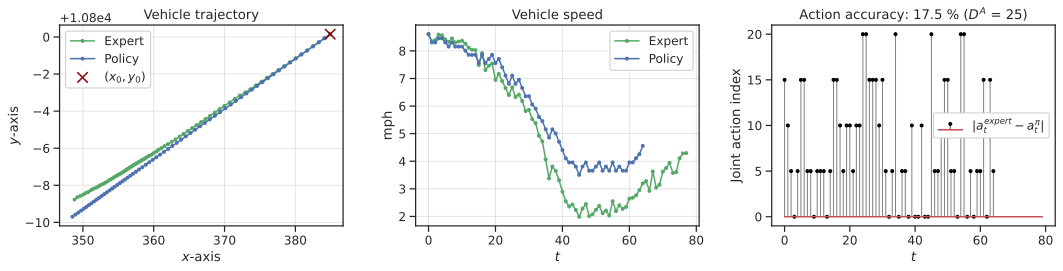

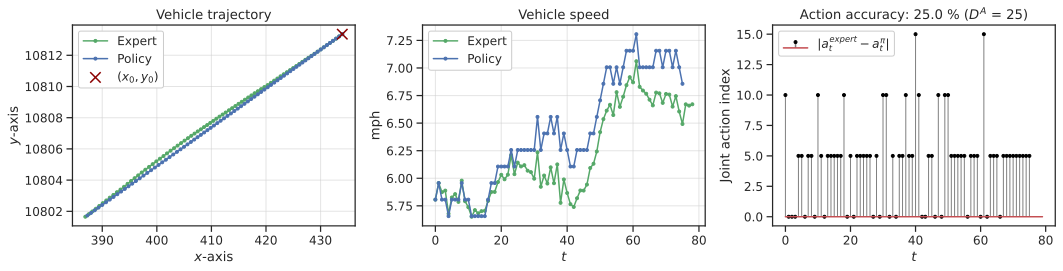

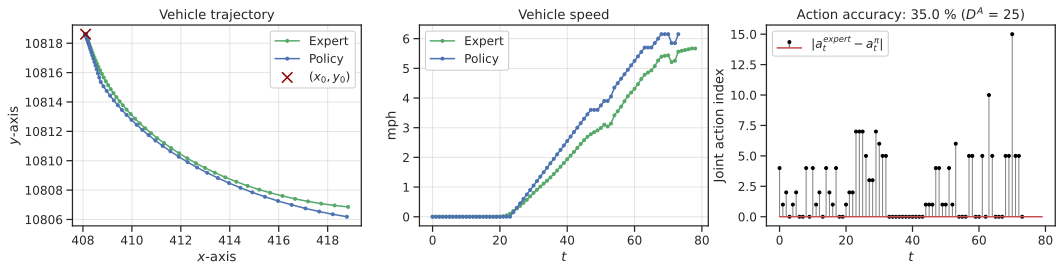

In [5]:
for agent_id in df_il_trajs.agent_id.unique():
    agent_df = df_il_trajs[df_il_trajs.agent_id == agent_id]
    plot_agent_trajectory(agent_df, evaluator.env.action_space.n)

### 1.2 Evaluate behavioral cloning policy ( $\tau$ ) | **2 scenes**

- Now we look at the results for a BC policy that has been trained on 2 files

In [15]:
# Set data path
env_config.data_path = "../data/train/"

# Load human reference policy
human_policy = load_policy(
    data_path="../models/il",
    file_name="human_policy_2_scenes_2023_11_22",   
)

# Evaluate policy
evaluator = EvaluatePolicy(
    env_config=env_config, 
    exp_config=exp_config,
    policy=human_policy,
    log_to_wandb=False,
    deterministic=True,
    reg_coef=0.0,
    return_trajectories=True,
)

df_il_res_2, df_il_trajs_2 = evaluator._get_scores()

Evaluating policy on tfrecord-00012-of-01000_389.json...
Evaluating policy on tfrecord-00001-of-01000_307.json...


In [16]:
df_il_res_2.head().round(2)

,run_id,traffic_scene,agents_controlled,reg_coef,act_acc,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr,num_violations
0,None,tfrecord-00012-of-01000_389.json,4,0.0,0.17,123.75,73.35,0.25,0.50,0.0,0
1,None,tfrecord-00001-of-01000_307.json,3,0.0,0.26,4.81,0.49,0.67,0.33,0.0,0


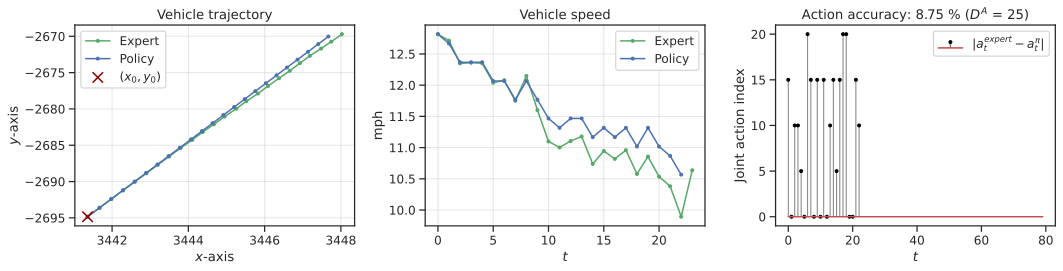

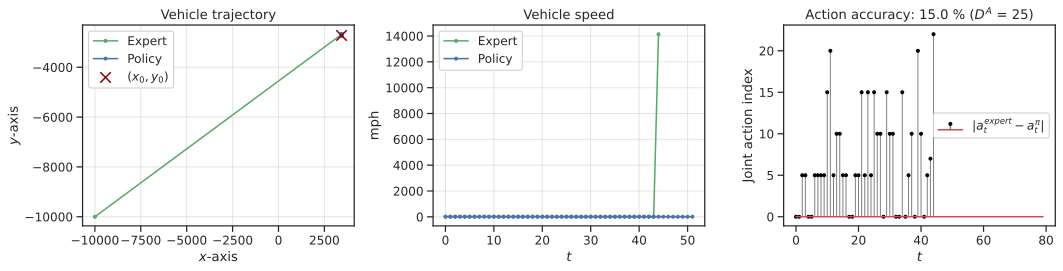

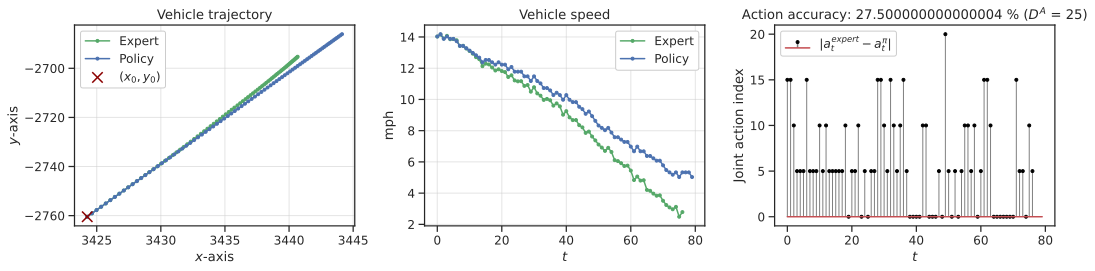

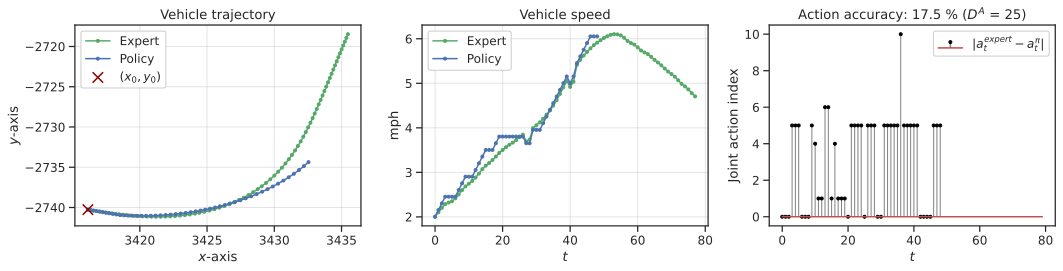

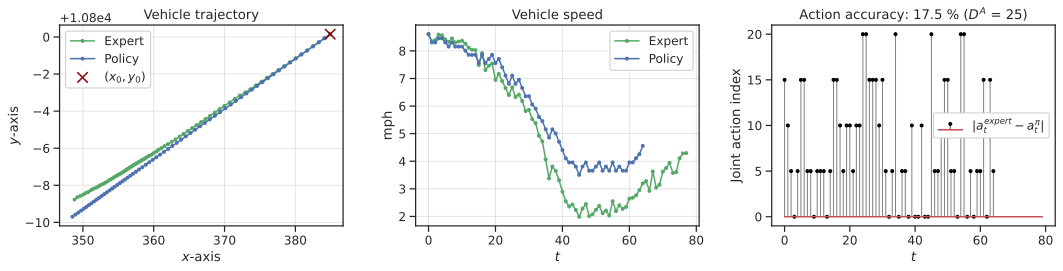

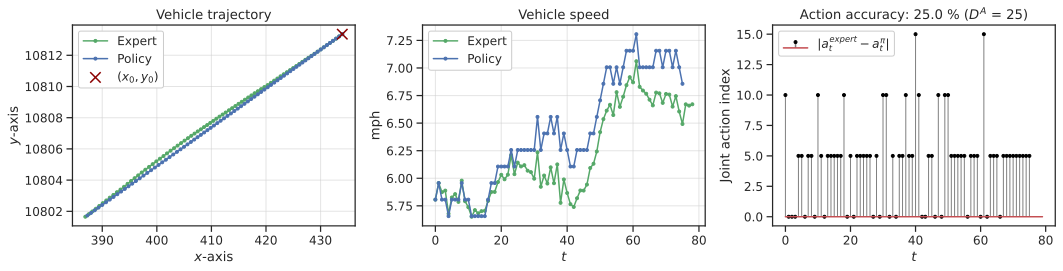

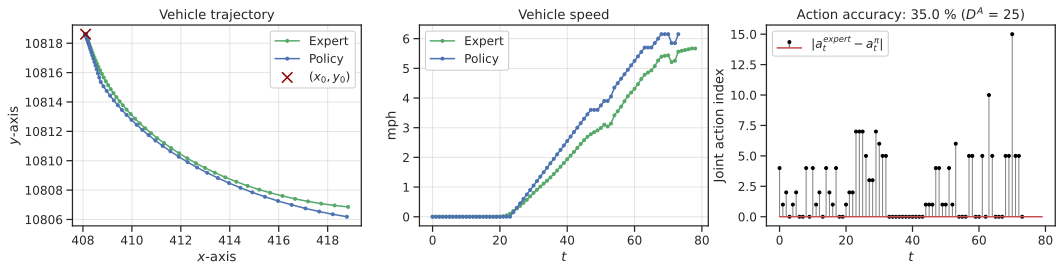

In [17]:
for scene_name in df_il_trajs_2.traffic_scene.unique():
    scene_df = df_il_trajs_2[df_il_trajs_2.traffic_scene == scene_name]
    
    for agent_id in scene_df.agent_id.unique():
        agent_scene_df = scene_df[scene_df.agent_id == agent_id]
        plot_agent_trajectory(agent_scene_df, evaluator.env.action_space.n)

### 2. Evaluate pure RL policies

### 3. Evaluate human-regularized RL policies